# Transfer learning for text categorization

In this notebook we showcase how to use Xfer to tackle a simple task of transfer learning for text categorization. To that end, we use the 20 newsgroups text dataset (http://qwone.com/~jason/20Newsgroups/) which is comprised of a collection of 20K newsgroups posts.

We use a Convolutional Neural Network (CNN) pre-trained on a subset of 13 classes (~12K instances). For the target task, we assume that we have access to a much smaller dataset with 100 posts from the remaining 7 categories. This is a common situation in many real world applications where the number of categories grows with time as we collect new data. In this case, we will always start with a low number of labelled instances for the new categories (this is the cold-start problem).

In this scenario, training a NN from scratch on the target task is not feasible: due to the scarcity of labeled instances (100 in this case) and the large number of parameters, the model will be prone to overfitting. Instead, we will use Xfer to transfer the knowledge from the source model and propose a data efficient classifier.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pickle
from collections import Counter
import itertools
import numpy as np
import mxnet as mx

import xfer

mx.random.seed(1)
np.random.seed(1)

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
config = {
    "source_vocab": "NewsGroupsSourceVocabulary.pickle",
    "model_prefix_source":'NewsGroupsSourceModel',
    "num_epoch_source": 100,
    "batch_size": 100,
    "num_train": 100,
    "context": mx.cpu(),
}

## A) Load the pre-trained model

Before building the target dataset, we load the pre-trained model into a mxnet `Module`. In this case, the pre-trained model is a CNN that was trained with instances beloging to the following 13 categories that are not used in the target task:

* comp.graphics
* comp.os.ms-windows.misc
* comp.sys.ibm.pc.hardware
* comp.windows.x
* misc.forsale
* rec.motorcycles
* rec.sport.baseball
* sci.crypt 
* sci.med
* sci.space
* talk.politics.mideast
* talk.politics.misc
* talk.religion.misc

In [3]:
import zipfile
with zipfile.ZipFile("{}-{:04}.params.zip".format(config["model_prefix_source"], config["num_epoch_source"]),"r") as zip_ref:
    zip_ref.extractall()

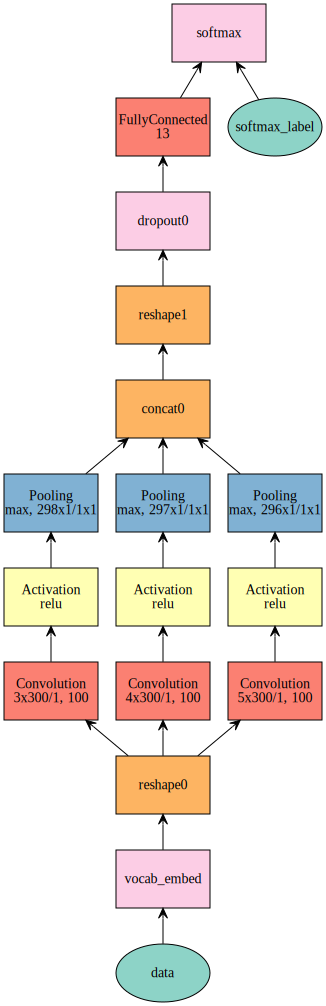

In [4]:
sym, arg_params, aux_params = mx.model.load_checkpoint(config["model_prefix_source"], config["num_epoch_source"])
mx.viz.plot_network(sym)

## B) Load the target dataset into an iterator

We define a helper function to download the dataset. The 7 classes used for the target task are the following:

* alt.atheism
* comp.sys.mac.hardware
* rec.autos
* rec.sport.hockey
* sci.electronics
* soc.religion.christian
* talk.politics.guns


In [5]:
def download_dataset():
    from sklearn.datasets import fetch_20newsgroups
    categories=['alt.atheism',
                 'comp.sys.mac.hardware',
                 'rec.autos',
                 'rec.sport.hockey',
                 'sci.electronics',
                 'soc.religion.christian',
                 'talk.politics.guns'
                ]

    newsgroups_train = fetch_20newsgroups(subset='train',categories=categories)
    newsgroups_test = fetch_20newsgroups(subset='test',categories=categories)

    x_text = np.concatenate((newsgroups_train.data, newsgroups_test.data), axis=0)
    labels = np.concatenate((newsgroups_train.target, newsgroups_test.target))
 
    return x_text, labels, categories 

In addition, we use two helper classes to create the corpus:
* **Vocabulary**: It creates the lexicon for a given corpus. In addition, it provides a basic string cleaning function based on regular expressions.
* **Corpus**: Given a corpus (text and labels) and a Vocabulary object, it converts the text instances into a numerical format. In particular, it uses the provided vocabulary object to tokenize and clean the text instances. Then, it pads the sentences using max_length/fix_length and the padding symbol defined in the vocabulary object. Finally, each token is encoded into a one-hot vector using the vocabulary. In addition, it provides a helper function to build the training and test sets.


In [6]:
class Vocabulary(object):
    def __init__(self, sentences, padding_word="</s>", unknown_word="</ukw>"):
        self.padding_word = padding_word
        self.unknown_word = unknown_word
        sentences = [self.clean_str(sent).split(" ") for sent in sentences]
        self.max_length = max(len(x) for x in sentences)
        self.word_counts = Counter(itertools.chain(*sentences))
        self.id2word = [x[0] for x in self.word_counts.most_common()]
        self.id2word.append(self.padding_word)
        self.id2word.append(self.unknown_word)
        self.word2id = {x: i for i, x in enumerate(self.id2word)}

        print('Vocabulary size', len(self.id2word))
        
    def clean_str(self, string):
        string = re.sub(r"[^A-Za-z0-9(),;!?\']", " ", string)
        contractions = ["\'t", "\'ve", "\'d", "\'s", "\'ll", "\'m", "\'er"]
        punctuations =  [",", ";", "!", "\?", "\)", "\("]
        for ee in contractions + punctuations:
            string = re.sub(r"{}".format(ee), " {} ".format(ee), string)
        return string.strip().lower()

In [7]:
class Corpus(object):
    def __init__(self, sentences, labels, vocabulary, max_length=None, fix_length=None):
        self.vocabulary = vocabulary
        self.max_length = max_length
        self.fix_length = fix_length
        sentences = [self.vocabulary.clean_str(sent).split(" ") for sent in sentences]
        sentences_padded = self._pad_sentences(sentences, self.vocabulary.padding_word, self.max_length, self.fix_length)
        x = []
        for sentence in sentences_padded:
            x.append([self.vocabulary.word2id.get(word, self.vocabulary.word2id[self.vocabulary.unknown_word]) for word in sentence])
        self.x = np.array(x)
        self.y = np.array(labels)

        print('Data shape:', self.x.shape)
        print('Vocabulary size', len(vocabulary.id2word))
        print('Maximum number words per sentence', self.x.shape[1])
        print('Number of labels', len(np.unique(self.y)))
        
    def _pad_sentences(self, sentences, padding_word="</s>", max_length=None, fix_length=None):
        sequence_length = max(len(x) for x in sentences)
        if max_length is not None:
            sequence_length = min(sequence_length, max_length)
        if fix_length is not None:
            sequence_length = fix_length
        padded_sentences = []
        for i in range(len(sentences)):
            sentence = sentences[i]
            if len(sentence) > sequence_length:
                sentence = sentence[0:sequence_length]
            num_padding = sequence_length - len(sentence)
            new_sentence = sentence + [padding_word] * num_padding
            padded_sentences.append(new_sentence)

        return padded_sentences  
    
    def split_train_test(self, num_train):
        shuffle_indices = np.random.permutation(np.arange(len(self.y)))
        x_shuffled = self.x[shuffle_indices]
        y_shuffled = self.y[shuffle_indices]
        x_train, x_dev = x_shuffled[:num_train], x_shuffled[num_train:]
        y_train, y_dev = y_shuffled[:num_train], y_shuffled[num_train:]
        
        print('Train/Test split: %d/%d' % (len(y_train), len(y_dev)))
        print('Train shape:', x_train.shape)
        print('Test shape:', x_dev.shape)

        return x_train, x_dev, y_train, y_dev

We import the vocabulary object of the source model

In [8]:
with open(config["source_vocab"], 'rb') as handle:
    vocab_source = pickle.load(handle)

We build the dataset for the target task and split it in training/test sets. Notice that we use only 100 instances for the training set since we care about scenarios in which the target dataset is small compared to the source dataset.

In [9]:
x_text, labels, categories = download_dataset()
corpus = Corpus(x_text, labels, vocab_source, fix_length=arg_params["vocab_embed_weight"].shape[1])
x_train, x_dev, y_train, y_dev = corpus.split_train_test(config["num_train"])

Data shape: (6642, 300)
Vocabulary size 149371
Maximum number words per sentence 300
Number of labels 7
Train/Test split: 100/6542
Train shape: (100, 300)
Test shape: (6542, 300)


We finally load the training/test datasets into mxnet iterators:

In [10]:
train_iter = mx.io.NDArrayIter(x_train, y_train, config['batch_size'], shuffle=True)
val_iter = mx.io.NDArrayIter(x_dev, y_dev, config['batch_size'], shuffle=False)

## C) How well we predict without repurposing?

We create a new mxnet `Module`, bind the training/test iterators and load the parameters of the pre-trained model.

In [11]:
mod = mx.mod.Module(symbol=sym,
                    context=config["context"],
                    data_names=['data'],
                    label_names=['softmax_label'])
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod.set_params(arg_params, aux_params)

In [12]:
mod.save_checkpoint("NewsGroupsSourceModelCompressed",1)

If we use the pre-trained network directly, we obtain a poor performance since it was trained for a different task (different set of classes).

In [13]:
y_predicted = mod.predict(val_iter).asnumpy().argmax(axis=1)
print("Accuracy score before repurposing: {}".format(np.mean((y_predicted == y_dev))))

Accuracy score before repurposing: 0.07169061449098135


## D) Repurposing

For this demo, we use one class of repurposers called `MetaModelRepurposer`. These are repurposers that use the pre-trained model as a feature extractor and fit a different model using the extracted features. In particular, we use an `LrRepurposer` which fits a logistic regression using the extracted features.

In [14]:
lr_repurposer = xfer.LrRepurposer(mod, ["dropout0"])
lr_repurposer.repurpose(train_iter)
y_predicted = lr_repurposer.predict_label(val_iter)

In [15]:
print("Accuracy score after repurposing: {}".format(np.mean((y_predicted == y_dev))))

Accuracy score after repurposing: 0.5889636196881688


Training the model from scratch results in an accuracy of approximately 0.5 and it is much slower to train having to resort to GPUs to speed up the process.

Finally, we show the full pipeline to categorize a new test example. In this case, we have used the first paragraphs of the wikipedia article for **"Automotive Electronics"**. (Feel free to replace it with your own example!!!)

In [16]:
test_example = ["""
Automotive electronics are electronic systems used in vehicles, including engine management, ignition, radio, carputers, telematics, in-car entertainment systems and others. Ignition, engine, and transmission electronics are also found in trucks, motorcycles, off-road vehicles, and other internal combustion-powered machinery such as forklifts, tractors, and excavators. Related elements for control of relevant electrical systems are found on hybrid vehicles and electric cars as well.

Electronic systems have become an increasingly large component of the cost of an automobile, from only around 1% of its value in 1950 to around 30% in 2010.[1]

The earliest electronics systems available as factory installations were vacuum tube car radios, starting in the early 1930s. The development of semiconductors after WWII greatly expanded the use of electronics in automobiles, with solid-state diodes making the automotive alternator the standard after about 1960, and the first transistorized ignition systems appearing about 1955. 
"""]

In [17]:
corpus = Corpus(test_example, [1], vocab_source, fix_length=arg_params["vocab_embed_weight"].shape[1])

Data shape: (1, 300)
Vocabulary size 149371
Maximum number words per sentence 300
Number of labels 1


In [18]:
test_example_iter = mx.io.NDArrayIter(corpus.x, corpus.y, len(corpus.y), shuffle=False)

In [19]:
y_predicted_prob = lr_repurposer.predict_probability(test_example_iter)

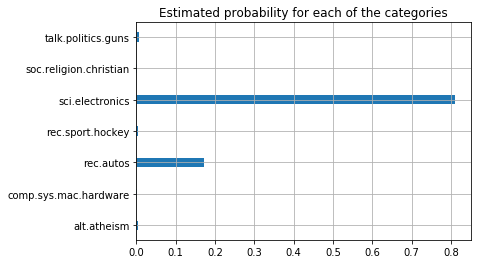

In [20]:
plt.barh(list(range(y_predicted_prob.shape[1])), y_predicted_prob[0,:], align='center', height=0.3)
plt.yticks(list(range(y_predicted_prob.shape[1])), categories)
plt.title("Estimated probability for each of the categories")
plt.grid(True)

We can see that the main two identified topics are electronics and autos, which is what we would expect given the title of the article. 